In [1]:
import torch
from torch import optim
import torchvision.transforms as tt

from utils import *
import config
import random

from Generator import Generator
from GANSSL import GANSSL, Discriminator

from tqdm.notebook import tqdm

In [2]:
print_config()

RANDOM_SEED   :                       11042004
DATA_DIR      :                         ./data
USED_DATA     :                         DOODLE
NUM_LABELLED  :                             -1
DEVICE        :                         cuda:0
GAN_BATCH_SIZE:                            128
WIDTH         :                            820
HEIGHT        :                            740
FPS           :                           None
DRAW_WIDTH    :                            640
DRAW_HEIGHT   :                            640
DATASETS      :  ['MNIST', 'DOODLE', 'EMNIST']
BLACK         :                      (0, 0, 0)
WHITE         :                (255, 255, 255)
BACKGROUND    :                (127, 127, 127)


In [3]:
set_random_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "GANSSL"

In [5]:
PATH = get_PATH(name)
PATH

'DOODLE/GANSSL/_full'

In [6]:

if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3

	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

else:

# if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [7]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [8]:
X_full = train_ds.x
y_full = train_ds.y

In [9]:
classes

['0 - helicopter',
 '1 - car',
 '2 - book',
 '3 - windmill',
 '4 - cat',
 '5 - umbrella',
 '6 - octopus',
 '7 - bird',
 '8 - hat',
 '9 - birthday cake']

In [10]:
latent_size = 100
n_classes = len(classes)
channels = X_full.shape[1]
n_classes, channels

(10, 1)

In [11]:
# test dataloader
test_dl = CreateDataLoader(test_ds, batch_size=512, device=config.DEVICE)

In [12]:
X_sup, y_sup = supervised_samples(X_full, y_full, config.NUM_LABELLED, n_classes) # type: ignore

In [13]:
generator = Generator(latent_size, channels)
discriminator = Discriminator(channels, n_classes)

In [14]:
model = GANSSL(generator, discriminator, latent_size, config.DEVICE)

In [15]:
model.load_gen_state_dict(f'GAN/{config.USED_DATA}/netG_epoch_009.pt')

In [16]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)
full_ds = CustomDataSet(X_full, y_full, train_tfm)

In [17]:
history = model.fit(10, 64, 50, 0.0001, sup_ds, full_ds, test_dl, optim.RMSprop, sched = False, PATH=PATH+".pt", save=False)

Epoch [0]:


  0%|          | 0/50 [00:00<?, ?it/s]

C_Loss: 1.57819, D_Loss: 0.14809
acc = 0.6989
Epoch [1]:


  0%|          | 0/50 [00:00<?, ?it/s]

C_Loss: 1.13808, D_Loss: 0.13206
acc = 0.8
Epoch [2]:


  0%|          | 0/50 [00:00<?, ?it/s]

C_Loss: 1.21167, D_Loss: 0.12694
acc = 0.8442
Epoch [3]:


  0%|          | 0/50 [00:00<?, ?it/s]

C_Loss: 1.03449, D_Loss: 0.12631
acc = 0.8481
Epoch [4]:


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
d = Discriminator(channels, n_classes).to(config.DEVICE)
d.load_state_dict(torch.load(f"{config.USED_DATA}/CNN/_{config.NUM_LABELLED}.pt"))
d.eval()
corrected = 0

for b in test_dl:
	images, labels = b
	outs = d.forward(images)
	_, preds = torch.max(outs, dim=1)
	outs = torch.argmax(outs, dim=1)
	corrected += torch.sum(preds == labels).item()

corrected / test_dl.num_data(), model.evaluate(test_dl)

(0.36427884615384615, 0.4922115384615385)

In [ ]:
import pickle

In [ ]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [ ]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

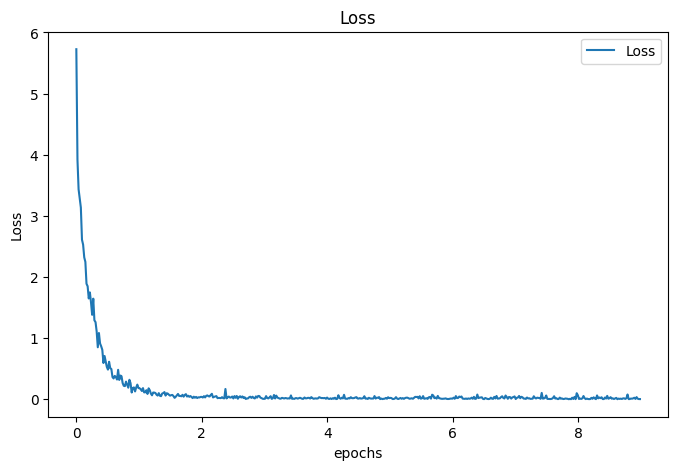

In [ ]:
plotting(history)